# Mount

# Install

In [1]:
cd voice-splitter/LibriSpeech

[WinError 3] The system cannot find the path specified: 'voice-splitter/LibriSpeech'
D:\antpi\code\voice-splitter\LibriSpeech


In [2]:
# !pip freeze > requirements.txt

In [3]:
# !pip install -r requirements.txt

In [4]:
from __future__ import division, print_function

## File management
from pathlib import Path
import os

## Sound
import soundfile as sf
import librosa
import scipy.io.wavfile as wavfile
from scipy import signal

## Plotting
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import cv2

## AI
import random
from tensorflow.keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Conv2D, UpSampling1D, Conv2DTranspose, Flatten, Dropout, MaxPooling1D, MaxPooling2D, AveragePooling2D, Bidirectional, Lambda, LeakyReLU, ReLU, PReLU, Dropout, Input, Add, Multiply, Reshape, BatchNormalization
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [5]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.1.0

# Setup

# Useful functions

In [404]:
def createDir(path):
    if os.path.exists(path):
        return
    os.mkdir(path)

def writeFile(path, data, samplerate, erase=False, verbose=False):
    if os.path.exists(path):
        if verbose:
            print("exists", path)
        if erase:
            os.remove(path)
            sf.write(path, data, samplerate)
    else:
        if verbose:
            print("exists not", path)
        sf.write(path, data, samplerate)
    
def explore(directory):
    X = []
    walk = os.walk(directory)
    for (path, folder, files) in walk:
        for file in files:
            x = os.path.join(path, file)
            X.append(x)
    return X
    
def train_clustering(data_dir, dataProcessor, labels_map, labelsCount, encoder):
    examples = explore(data_dir)
    random.shuffle(examples)
    
    labels = [labels_map[dataProcessor.getLabels(example)[0]] for example in examples]
    pred_generator = DataGenerator(dataProcessor, examples, [], labels_map, n_classes=labelsCount, batch_size=1, to_fit=False, shuffle=False)
    encodings = encoder.predict(pred_generator)
    kmeans = KMeans(n_clusters=labelsCount).fit(encodings)
    diff = kmeans.labels_ - np.array(labels)
    print(diff)
    errors = diff[diff != 0]
    print(len(errors))
    print(len(diff))
    print(f"Finished kmeans clustering, weighted error rate: {len(errors)/len(kmeans.labels_)}")
    return kmeans, diff, np.array(labels)
        
## Class responsible for preprocessing  
class DataProcessor():
    def __init__(self, audio_dir, uncut_audio_dir=None, wav_dir=None, data_dir=None, duration = 1, sr=8000, folder_sep='\\', title_sep='-', label_pos=0):      
        self.audio_dir = audio_dir
        self.uncut_audio_dir = uncut_audio_dir
        self.wav_dir = wav_dir
        self.data_dir = data_dir
        self.folder_sep = folder_sep
        self.title_sep = title_sep
        self.label_pos = label_pos
        self.duration = duration
        self.sr = sr
        self.dim = int(sr*duration)
        
        self.flacToWav()
        self.cutData()
        self.trainTestSplit()
        self.mapLabels()

    def getLabels(self, path):
        # Path should be of the form f"{audio_dir}/{author1}/{author2}/..."
        labels=set()
        subfolders = path.split(self.folder_sep)[1:]
        for name in subfolders:
            author_ID = name.split(self.title_sep)[self.label_pos]
            labels.add(author_ID)
        return list(labels)
    
    def getNameFromTitle(self, path):
        # Path should be of the form f"{audio_dir}/{__-__-author1-__-__}/{id}" where the id is in position self.label_pos
        # Returns the last {author_k}
        subfolders = path.split(self.folder_sep)
        title = subfolders[1]
        return title.split(self.title_sep)[self.label_pos]
    
    def getIDFromTitle(self, path):
        # Path should be of the form "{audio_dir}/{author1}/{author2}/.../{id}"
        # Returns {id}
        return path.split(self.folder_sep)[-1]
    
    def getNames(self, path):
        # Path should be of the form "{audio_dir}/{author1}/{author2}/.../{id}"
        # Returns [{author1}, {author2}, ...]
        names = path.split(self.folder_sep)[1:-1]
        return names
    
    def getSubDir(self, path):
        # Path is "{audio_dir}/{author}/{id.wav}", 
        # Returns "{audio_dir}/{author}"
        return path.strip(self.getIDFromTitle(path))

    def cutSoundFile(self, path):
        # Cut sound file into extracts that each last self.duration, get rid of last extract if too short
        data, sr = librosa.load(path)
        samples = int(sr * self.duration)
        sound_files = [data[i:i + samples] for i in range(0, len(data), samples)]
        sound_files = [sound_file for sound_file in sound_files if len(sound_file) == samples]
        sound_files = [librosa.resample(sound_file, sr, self.sr) for sound_file in sound_files]
        return sound_files, self.sr, path
    
    def flacToWav(self):
        if self.wav_dir is not None and self.data_dir is not None and not explore(self.wav_dir):
            print("-- Converting .flac to .wav")
            X = explore(self.data_dir)
            for (k, x) in enumerate(X):
                if k%(len(X)//10) == 0:
                    print(f"{k}/{len(X)} = {k*100//len(X)}%")
                if x.endswith('.flac'):
                    name = self.getNameFromTitle(x)
                    _id = self.getIDFromTitle(x).replace('.flac', '.wav')
                    path = os.path.join(self.wav_dir, name, _id)
                    subdir = self.getSubDir(path)
                    data, samplerate = sf.read(x)
                    p = Path(subdir)
                    p.mkdir(parents=True, exist_ok=True)
                    sf.write(path, data, samplerate)
            
    def trainTestSplit(self, ratio=0.2):
        print("-- Splitting data into train and test")
        X = explore(self.audio_dir)
        self.partition_x = {
            'train': [],
            'test': []
        }
        self.partition_y = {
            'train': [],
            'test': []
        }
        self.n_train = 0
        self.n_test = 0        
        for (k, x) in enumerate(X):
            if k%(len(X)//10) == 0:
                print(f"{k}/{len(X)} = {k*100//len(X)}%")
            y = self.getLabels(x)
            if random.uniform(0, 1) < ratio:
                self.n_test += 1
                self.partition_x['test'].append(x)
                self.partition_y['test'].append(y) 
            else:
                self.n_train += 1
                self.partition_x['train'].append(x)
                self.partition_y['train'].append(y) 
        print("--- Finished train-test split ---")
        print(f"n-train : {self.n_train}")
        print(f"n-test : {self.n_test}")
        return self.partition_x, self.partition_y, self.n_train, self.n_test

    def mapLabels(self):
        print("-- Mapping labels")
        X = explore(self.audio_dir)
        labelsCount = 0
        self.labels_map = {}
        for (k, x) in enumerate(X):
            if k%(len(X)//10) == 0:
                print(f"{k}/{len(X)} = {k*100//len(X)}%")
            Y = self.getLabels(x)
            for y in Y:
                if not y in self.labels_map:
                    self.labels_map[y] = labelsCount
                    labelsCount += 1
        return self.labels_map, labelsCount
    
    def cutData(self):
        if self.uncut_audio_dir is not None and not explore(self.audio_dir):
            print("-- Cutting sound files into same-length extracts")
            X = explore(self.uncut_audio_dir)
            for (k, x) in enumerate(X):
                if k%(len(X)//10) == 0:
                    print(f"{k}/{len(X)} = {k*100//len(X)}%")
                sound_files, sr, path = self.cutSoundFile(x)
                for (k, sound_file) in enumerate(sound_files):
                    output_path = path.replace(self.uncut_audio_dir, self.audio_dir).replace('.wav', f"{self.title_sep}{k}.wav")
                    subdir = self.getSubDir(output_path)
                    p = Path(subdir)
                    p.mkdir(parents=True, exist_ok=True)
                    wavfile.write(output_path, self.sr, sound_file)

# Data generator

In [412]:
# A data structure that keras can get data from
class DataGenerator(Sequence):
    # Generates data for Keras
    def __init__(self, dataProcessor, list_IDs, labels, labels_map, to_fit=True, batch_size=16, n_channels=1, n_classes=40, shuffle=True, init_shuffle=False):
        # Initialization
        self.dataProcessor = dataProcessor
        self.list_IDs = list_IDs
        self.labels = labels
        self.labels_map = labels_map
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.sr = dataProcessor.sr
        self.duration = dataProcessor.duration
        self.dim = dataProcessor.dim
        self.shuffle = shuffle
        self.init_shuffle = init_shuffle
        
        self.on_epoch_end()
        
        if self.init_shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate one batch of data
        ## Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]

        ## Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        ## Generate data
        x = self._generate_x(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return x, y
        else:
            return x

    def _generate_x(self, list_IDs_temp):
        # Generates data containing batch_size images
        ## Initialization
        x = np.empty((self.batch_size, self.dim))

        ## Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x[i,] = self._load_wav(ID)
        return x
    
    def _load_wav(self, ID):
        sr, data = wavfile.read(ID)
        data = librosa.resample(data, sr, self.sr)
        return data

    def _generate_y(self, list_IDs_temp):
        # Generates data containing batch_size masks
        y = np.zeros((self.batch_size, self.n_classes), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            label = self._get_label(ID)
            y[i,] = label
        return y
    
    def _get_label(self, path):
        # Path should be of the form "{spectrogram_dir}/{author1-*}/{author2-*}"
        classes = np.zeros(self.n_classes)
        labels = self.dataProcessor.getLabels(path)
        for label in labels:
            class_ID = self.labels_map[label]
            classes[class_ID]=1
        return classes
    
# Same, but returns 2 files when called, with output = output1 + output2
class DoubleDataGenerator(Sequence):
    def __init__(self, 
                 dataProcessor, 
                 list_IDs, 
                 labels, 
                 labels_map,                  
                 batch_size=16, 
                 n_channels=1, 
                 n_classes=40,
                 to_fit=True, 
                 init_shuffle=False, 
                 shuffle=True):
        self.dataGen1 = DataGenerator(dataProcessor, list_IDs, labels, labels_map, to_fit=to_fit, batch_size=batch_size, n_channels=n_channels, n_classes=n_classes, shuffle=shuffle, init_shuffle=init_shuffle)
        self.dataGen2 = DataGenerator(dataProcessor, list_IDs, labels, labels_map, to_fit=to_fit, batch_size=batch_size, n_channels=n_channels, n_classes=n_classes, shuffle=shuffle, init_shuffle=init_shuffle)
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        
    def __len__(self):
        return int(np.floor(len(self.dataGen1.list_IDs) / self.dataGen1.batch_size))
    
    def on_epoch_end(self):
        self.dataGen1.on_epoch_end()
        self.dataGen2.on_epoch_end()
    
    def __getitem__(self, index):
        if self.dataGen1.to_fit:
            x1, y1 = self.dataGen1.__getitem__(index)
            x2, y2 = self.dataGen2.__getitem__(index)
            return ([x1, x2], y1+y2)
        else:
            x1 = self.dataGen1.__getitem__(index)
            x2 = self.dataGen2.__getitem__(index)
        return [x1, x2]

    def _generate_X(self, list_IDs_temp):
        X1 = self.dataGen1._generate_X(list_IDs_temp)
        X2 = self.dataGen2._generate_X(list_IDs_temp)
        return [X1, X2]

    def _generate_y(self, list_IDs_temp):
        y1 = self.dataGen1._generate_y(list_IDs_temp)
        y2 = self.dataGen2._generate_y(list_IDs_temp)
        return y1+y2

# Loss functions

In [413]:
def SNR(y_true, y_pred):    
    signal_norm = K.mean(K.square(y_true))
    noise_norm = K.mean(K.square(y_true-y_pred))
    return -10. * K.log(signal_norm/noise_norm)

def SI_SNR(y_true, y_pred):    
    s_hat = y_pred - K.mean(y_pred)
    s = y_true - K.mean(y_true)
    s_target = K.sum(s*s_hat)*s / K.sum(K.square(s))
    noise = s_hat - s_target
    Ps = K.sum(K.square(s_target))
    Pn = K.sum(K.square(noise))
    si_snr = 10. / np.log(10) * K.log(Pn/Ps)
    return si_snr

# Run

## Functional but easy: Recognizing both speakers when they speak at once on digit-dataset

In [414]:
cd ../digit-dataset

D:\antpi\code\voice-splitter\digit-dataset


In [415]:
data_dir = 'digit-dataset'
wav_dir = None
audio_dir = data_dir + "-recordings"
uncut_audio_dir = data_dir

dataP = DataProcessor(audio_dir, uncut_audio_dir=uncut_audio_dir, data_dir=data_dir, duration=0.2, sr=8000, title_sep="_", label_pos=1)
dataG = DataGenerator(dataP, dataP.partition_x["train"], dataP.partition_y["train"], dataP.labels_map, to_fit=True)

double_training_generator = DoubleDataGenerator(dataP, dataP.partition_x["train"], dataP.partition_y["train"], dataP.labels_map, n_classes=4)
double_validation_generator = DoubleDataGenerator(dataP, dataP.partition_x["test"], dataP.partition_y["test"], dataP.labels_map, n_classes=4, shuffle=False, init_shuffle=True)

-- Splitting data into train and test
0/3049 = 0%
304/3049 = 9%
608/3049 = 19%
912/3049 = 29%
1216/3049 = 39%
1520/3049 = 49%
1824/3049 = 59%
2128/3049 = 69%
2432/3049 = 79%
2736/3049 = 89%
3040/3049 = 99%
--- Finished train-test split ---
n-train : 2462
n-test : 587
-- Mapping labels
0/3049 = 0%
304/3049 = 9%
608/3049 = 19%
912/3049 = 29%
1216/3049 = 39%
1520/3049 = 49%
1824/3049 = 59%
2128/3049 = 69%
2432/3049 = 79%
2736/3049 = 89%
3040/3049 = 99%


In [416]:
dataP.labels_map

{'jackson': 0, 'nicolas': 1, 'theo': 2, 'yweweler': 3}

In [417]:
input_1 = Input(shape=(dataP.dim,), name='input_1')
in_1 = Reshape((dataP.dim, 1))(input_1)
input_2 = Input(shape=(dataP.dim,), name='input_2')
in_2 = Reshape((dataP.dim, 1))(input_2)
added = Add()([in_1, in_2])

conv_1 = Conv1D(64, 1)(added)
leek_1 = LeakyReLU()(conv_1)
pool_1 = MaxPooling1D()(leek_1)
conv_2 = Conv1D(64, 1)(pool_1)
leek_2 = LeakyReLU()(conv_2)
pool_2 = MaxPooling1D()(leek_2)

conv_3 = Conv1D(64, 1)(pool_2)
leek_3 = LeakyReLU()(conv_3)
pool_3 = MaxPooling1D()(leek_3)
conv_4 = Conv1D(64, 1)(pool_3)
leek_4 = LeakyReLU()(conv_4)
pool_4 = MaxPooling1D()(leek_4)

conv_5 = Conv1D(64, 1)(pool_4)
leek_5 = LeakyReLU()(conv_5)
pool_5 = MaxPooling1D()(leek_5)
conv_6 = Conv1D(64, 1)(pool_5)
leek_6 = LeakyReLU()(conv_6)
pool_6 = MaxPooling1D()(leek_6)

flat = Flatten()(leek_6)
dense_1 = Dense(64)(flat)
dense_2 = Dense(64)(dense_1)
decoder_output = Dense(double_training_generator.n_classes)(dense_2)

autoencoder = Model(inputs=[input_1, input_2], outputs=[decoder_output], name='autoencoder')
autoencoder.summary()

autoencoder.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1600)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1600)         0                                            
__________________________________________________________________________________________________
reshape_34 (Reshape)            (None, 1600, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_35 (Reshape)            (None, 1600, 1)      0           input_2[0][0]                    
________________________________________________________________________________________

In [418]:
autoencoder.fit(double_training_generator, validation_data=double_validation_generator, epochs=20)

Epoch 1/20
153/153 [==============================] - 2s 16ms/step - loss: 0.3050 - accuracy: 0.6295 - val_loss: 0.1559 - val_accuracy: 0.7656
Epoch 2/20
153/153 [==============================] - 2s 13ms/step - loss: 0.2314 - accuracy: 0.7582 - val_loss: 0.6499 - val_accuracy: 0.7795
Epoch 3/20
153/153 [==============================] - 2s 12ms/step - loss: 0.2057 - accuracy: 0.8002 - val_loss: 0.4587 - val_accuracy: 0.7639
Epoch 4/20
153/153 [==============================] - 2s 12ms/step - loss: 0.1878 - accuracy: 0.8051 - val_loss: 0.5176 - val_accuracy: 0.8229
Epoch 5/20
153/153 [==============================] - 2s 13ms/step - loss: 0.1782 - accuracy: 0.7868 - val_loss: 0.3948 - val_accuracy: 0.7812
Epoch 6/20
153/153 [==============================] - 2s 13ms/step - loss: 0.1774 - accuracy: 0.7733 - val_loss: 0.3935 - val_accuracy: 0.8090
Epoch 7/20
153/153 [==============================] - 2s 13ms/step - loss: 0.1671 - accuracy: 0.8039 - val_loss: 0.6471 - val_accuracy: 0.7413

In [301]:
double_training_generator[0]

ValueError: could not broadcast input array from shape (4410) into shape (1600)

In [161]:
def evaluate_classify(theta, X, dataProcessor, labelsMapping, predictions):
    c=0
    for k in range(len(predictions)):
        prediction = predictions[k]
        real_labels = labels[k]
        example = X[k]
        best = np.arange(len(prediction))
        real = np.arange(len(real_labels))
        best = set(best[prediction>theta])
        real = set(real[real_labels==1])
        if real == best:
            c+=1
    accuracy = c/len(predictions)
    return accuracy


def evaluate(X, dataProcessor, labelsMapping, predictions):
    accuracies=[]
    thetas=[]
    for theta in np.linspace(0, 1.5, 51):
        accuracy = evaluate_classify(theta, X, dataProcessor, labelsMapping, predictions)
        accuracies.append(accuracy)
        thetas.append(theta)
#     plt.plot(thetas, accuracies)
    best_index = np.argmax(accuracies)
    best_theta = thetas[best_index]
    best_accuracy = accuracies[best_index]
    return (best_theta, best_accuracy)
    
double_pediction_generator = DoubleDataGenerator(dataProcessor, partition_x["test"], partition_y["test"], labelsMapping, n_classes=labelsCount, batch_size=len(partition_x["test"]), to_fit=True, shuffle=False, init_shuffle=True)
examples, labels = double_pediction_generator.__getitem__(0)
predictions = autoencoder.predict(examples)

best_thetas = []
best_accuracies = []
epochs = []
for k in range(30):
    autoencoder.fit(double_training_generator, validation_data=double_validation_generator, epochs=1)
    predictions = autoencoder.predict(examples)
    theta, accuracy = evaluate(partition_x["test"], dataProcessor, labelsMapping, predictions)
    best_thetas.append(theta)
    best_accuracies.append(accuracy)
    epochs.append(k)
    
plt.plot(epochs, best_accuracies)
plt.plot(epochs, thetas)

NameError: name 'dataProcessor' is not defined

## Using masks to reconstruct original pictures with 2 known authors

In [19]:
cd ../digit-dataset

D:\antpi\code\voice-splitter\digit-dataset


In [130]:
data_dir = 'digit-dataset'
audio_dir_1 = data_dir + "-recordings-1"
audio_dir_2 = data_dir + "-recordings-2"
spectrogram_dir_1 = data_dir + "-spectrograms-1" # Has spectrograms for Jackson
spectrogram_dir_2 = data_dir + "-spectrograms-2" # Has spectrograms for Nicolas

dataProcessor_1 = DataProcessor(
    audio_dir_1, 
    spectrogram_dir_1, 
    folder_sep = '\\', 
    title_sep = '_', 
    label_pos = 1
)
partition_x_1, partition_y_1, _, _ = dataProcessor_1.trainTestSplit(spectrogram_dir_1)
_, labelsCount_1 = dataProcessor_1.mapLabels(spectrogram_dir_1)
dataGen1_train = AutoDataGenerator(dataProcessor_1, partition_x_1["train"])
dataGen1_test = AutoDataGenerator(dataProcessor_1, partition_x_1["test"])

dataProcessor_2 = DataProcessor(
    audio_dir_2, 
    spectrogram_dir_2, 
    folder_sep = '\\', 
    title_sep = '_', 
    label_pos = 1
)
partition_x_2, partition_y_2, _, _ = dataProcessor_2.trainTestSplit(spectrogram_dir_2)
_, labelsCount_2 = dataProcessor_2.mapLabels(spectrogram_dir_2)
dataGen2_train = AutoDataGenerator(dataProcessor_2, partition_x_2["train"], to_fit=False)
dataGen2_test = AutoDataGenerator(dataProcessor_2, partition_x_2["test"], to_fit=False)

double_auto_training_generator = DoubleAutoDataGenerator(dataGen1_train, dataGen2_train)
double_auto_validation_generator = DoubleAutoDataGenerator(dataGen1_test, dataGen2_test)

--- Finished train-test split ---
n-train : 458
n-test : 42
--- Finished train-test split ---
n-train : 448
n-test : 52


In [131]:
input_1 = Input(shape=SPECTROGRAM_DIMENSIONS, name='input_1')
input_2 = Input(shape=SPECTROGRAM_DIMENSIONS, name='input_2')
added = Add()([input_1, input_2])

x = Conv1D(128, 3)(added)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
dropout = Dropout(0.2)(x)

x1 = Conv1D(128, 4)(dropout)
x1 = LeakyReLU()(x1)
x1 = UpSampling1D(size=3)(x1)
x1 = Conv1D(128, 2)(x1)
x1 = LeakyReLU()(x1)
x1 = UpSampling1D()(x1)
x1 = Conv1D(128, 1)(x1)
x1 = LeakyReLU()(x1)
x1 = UpSampling1D()(x1)
mask_1 = Conv1D(128, 1, activation="sigmoid")(x1)
out_1 = Multiply()([added, mask_1])


x2 = Conv1D(128, 4)(dropout)
x2 = LeakyReLU()(x2)
x2 = UpSampling1D(size=3)(x2)
x2 = Conv1D(128, 2)(x2)
x2 = LeakyReLU()(x2)
x2 = UpSampling1D()(x2)
x2 = Conv1D(128, 1)(x2)
x2 = LeakyReLU()(x2)
x2 = UpSampling1D()(x2)
mask_2 = Conv1D(128, 1, activation="sigmoid")(x2)
out_2 = Multiply()([added, mask_2])


autoencoder = Model(inputs=[input_1, input_2], outputs=[out_1, out_2], name='autoencoder')
autoencoder.summary()
autoencoder.compile(optimizer='adam',
              loss=SI_SNR)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
add_28 (Add)                    (None, 128, 128)     0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_259 (Conv1D)             (None, 126, 128)     49280       add_28[0][0]           

In [132]:
input_1 = Input(shape=SPECTROGRAM_DIMENSIONS, name='input_1')
input_2 = Input(shape=SPECTROGRAM_DIMENSIONS, name='input_2')
added = Add()([input_1, input_2])

x = Conv1D(128, 3, padding="same")(added)
x = PReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding="same")(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding="same")(x)
x = PReLU()(x)
x = BatchNormalization()(x)
dropout = Dropout(0.2)(x)
x = MaxPooling1D(2)(x)

x1 = Conv1D(128, 3, padding="same")(dropout)
x1 = PReLU()(x1)
x1 = UpSampling1D(size=2)(x1)
x1 = Conv1D(128, 3, padding="same")(x1)
x1 = PReLU()(x1)
x1 = UpSampling1D(size=2)(x1)
x1 = Conv1D(128, 3, padding="same")(x1)
x1 = PReLU()(x1)
mask_1 = Conv1D(128, 3, padding="same", activation="sigmoid")(x1)
out_1 = Multiply()([added, mask_1])

x2 = Conv1D(128, 3, padding="same")(dropout)
x2 = PReLU()(x2)
x2 = UpSampling1D(size=2)(x2)
x2 = Conv1D(128, 3, padding="same")(x2)
x2 = PReLU()(x2)
x2 = UpSampling1D(size=2)(x2)
x2 = Conv1D(128, 3, padding="same")(x2)
x2 = PReLU()(x2)
mask_2 = Conv1D(128, 3, padding="same", activation="sigmoid")(x2)
out_2 = Multiply()([added, mask_2])


autoencoder = Model(inputs=[input_1, input_2], outputs=[out_1, out_2], name='autoencoder')
autoencoder.summary()
autoencoder.compile(optimizer='adam',
              loss=SI_SNR)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
add_29 (Add)                    (None, 128, 128)     0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_270 (Conv1D)             (None, 128, 128)     49280       add_29[0][0]           

In [137]:
autoencoder.fit(double_auto_training_generator, validation_data=double_auto_validation_generator, epochs=20)

Epoch 1/20
28/28 [==============================] - 1s 27ms/step - loss: -11.6480 - multiply_49_loss: -6.3627 - multiply_50_loss: -5.2853 - val_loss: -6.9837 - val_multiply_49_loss: -3.7626 - val_multiply_50_loss: -3.4824
Epoch 2/20
28/28 [==============================] - 1s 27ms/step - loss: -11.6689 - multiply_49_loss: -6.3745 - multiply_50_loss: -5.2944 - val_loss: -4.9294 - val_multiply_49_loss: -3.1791 - val_multiply_50_loss: -1.2150
Epoch 3/20
28/28 [==============================] - 1s 30ms/step - loss: -11.4836 - multiply_49_loss: -6.3043 - multiply_50_loss: -5.1793 - val_loss: -9.6872 - val_multiply_49_loss: -5.4682 - val_multiply_50_loss: -3.8844
Epoch 4/20
28/28 [==============================] - 1s 25ms/step - loss: -11.9656 - multiply_49_loss: -6.5270 - multiply_50_loss: -5.4387 - val_loss: -7.5719 - val_multiply_49_loss: -4.4676 - val_multiply_50_loss: -3.1419
Epoch 5/20
28/28 [==============================] - 1s 26ms/step - loss: -11.8832 - multiply_49_loss: -6.4864 - 

In [138]:
n_batches = len(double_auto_validation_generator)
k = random.randint(0, n_batches)
examples_doubled=double_auto_validation_generator[k][0]
ex1_batch, ex2_batch = examples_doubled
n_samples = len(ex1_batch)
random.shuffle(ex1_batch)
ex1 = ex1_batch[0]
random.shuffle(ex2_batch)
ex2 = ex2_batch[0]
batches = [ex1_batch, ex2_batch]
predictions = autoencoder.predict(batches)

--Spec 1--
--Spec 2--
--Both--


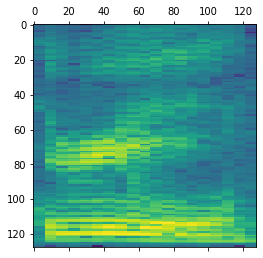

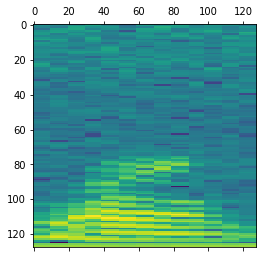

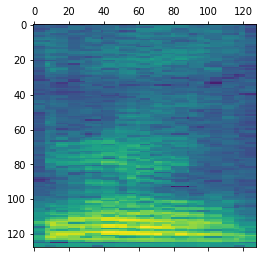

In [154]:
n_batches = len(double_auto_validation_generator)
k = random.randint(0, n_batches)
examples_doubled=double_auto_validation_generator[k][0]
ex1_batch, ex2_batch = examples_doubled
n_samples = len(ex1_batch)
random.shuffle(ex1_batch)
ex1 = ex1_batch[0]
random.shuffle(ex2_batch)
ex2 = ex2_batch[0]
batches = [ex1_batch, ex2_batch]
predictions = autoencoder.predict(batches)

spec1 = ex1.reshape((128,128))
pred1 = predictions[0][0]
pred_spec_1 = pred1.reshape((128,128))
diff1 = spec1-pred_spec_1
# print(np.max(diff1)/np.max(pred1))
print("--Spec 1--")
plt.matshow(spec1)
# print("--Pred 1--")
# plt.matshow(pred_spec_1)
# print("--Diff 1--")
# plt.matshow(diff1)

spec2 = ex2.reshape((128,128))
pred2 = predictions[0][1]
pred_spec_2 = pred2.reshape((128,128))
diff2 = spec2-pred_spec_2
# print(np.max(diff2)/np.max(pred2))
print("--Spec 2--")
plt.matshow(spec2)
# print("--Pred 2--")
# plt.matshow(pred_spec_2)
# print("--Diff 2--")
# plt.matshow(diff2)

spec = spec1+spec2
print("--Both--")
plt.matshow(spec)

0.5251384351251059


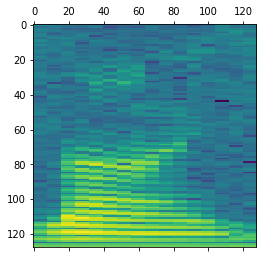

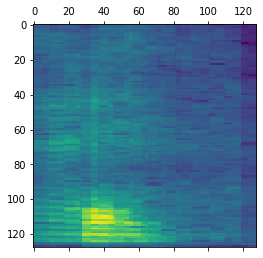

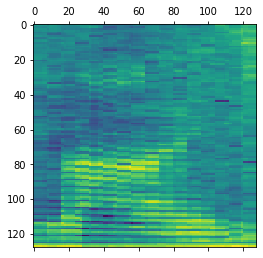

In [145]:
n_batches = len(double_auto_training_generator)
k = random.randint(0, n_batches)
examples_doubled=double_auto_training_generator[k][0]
ex1_batch, ex2_batch = examples_doubled
n_samples = len(ex1_batch)
random.shuffle(ex1_batch)
ex1 = ex1_batch[0]
random.shuffle(ex2_batch)
ex2 = ex2_batch[0]
batches = [ex1_batch, ex2_batch]
predictions = autoencoder.predict(batches)

spec2 = ex2.reshape((128,128))
pred2 = predictions[0][1]
pred_spec_2 = pred2.reshape((128,128))
diff2 = spec2-pred_spec_2
print(np.max(diff2)/np.max(pred2))
plt.matshow(spec2)
plt.matshow(pred_spec_2)
plt.matshow(diff2)


NameError: name 'sess' is not defined

0.3748256662172763


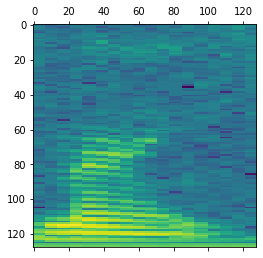

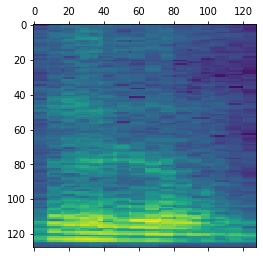

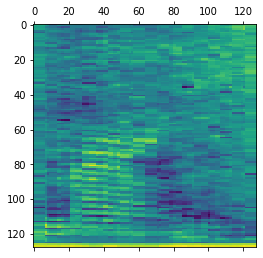

In [81]:
spec2 = ex2.reshape((128,128))
pred2 = predictions[0][1]
pred_spec_2 = pred2.reshape((128,128))
diff2 = spec2-pred_spec_2
print(np.max(diff2)/np.max(pred2))
plt.matshow(spec2)
plt.matshow(pred_spec_2)
plt.matshow(diff2)

# Test

In [11]:
np.random.random(30)

array([0.29168153, 0.46668703, 0.23765396, 0.75775788, 0.61512461,
       0.07152913, 0.54229938, 0.54839354, 0.81475662, 0.65263818,
       0.86334199, 0.25302543, 0.89028553, 0.29036215, 0.92865215,
       0.76919179, 0.9253494 , 0.80433911, 0.51018797, 0.34713318,
       0.9798837 , 0.43440747, 0.70824782, 0.94744015, 0.9376553 ,
       0.1041424 , 0.98339708, 0.62256562, 0.40888042, 0.67031399])

# Other - Learning to invert with a very small model

In [341]:
def f(X):
    return np.sum(X**3)
a, b = -1, 1

In [366]:
m=1
def makeData(n, a=-1.2, b=1.2):
    # Make data points in (a, b)
    X=np.zeros((n, m))
    for k in range(n):
        X[k] = np.random.random(m)*(b-a)+a
    return X

In [367]:
n = 50000
thresh = int(n*0.8)
normalize = 100
X = makeData(n)
X_t = X[0:thresh]
X_v = X[thresh::]
Y_t = np.array([f(x_t) for x_t in X_t]) / normalize
Y_v = np.array([f(x_v) for x_v in X_v]) / normalize

In [368]:
# Design model
from keras.layers import LeakyReLU, PReLU, ReLU

model = Sequential()
model.add(Dense(m))
model.add(LeakyReLU())
# model.add(Dense(3))
# model.add(LeakyReLU())
# model.add(Dense(3))
# model.add(LeakyReLU())
model.add(Dense(10))
model.add(LeakyReLU())
model.add(Dense(10))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

In [373]:
model.fit(X_t, Y_t, epochs = 4)

Epoch 1/4
40000/40000 [==============================] - 3s 78us/step - loss: 8.6458e-06
Epoch 2/4
40000/40000 [==============================] - 3s 79us/step - loss: 5.3142e-06
Epoch 3/4
40000/40000 [==============================] - 3s 80us/step - loss: 3.9708e-06
Epoch 4/4
40000/40000 [==============================] - 3s 78us/step - loss: 3.5766e-06


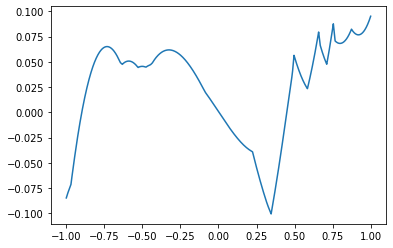

In [374]:
exple = np.linspace(a,b,10001)
th = np.array([[f(a)] for a in exple]) / normalize
y = model.predict(exple)
diff = th-y
plt.plot(exple, diff*100)

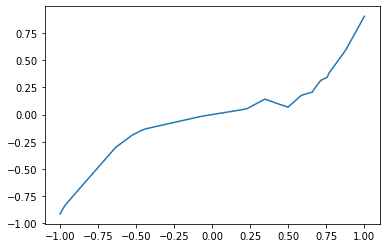

In [375]:
plt.plot(exple, y*100)

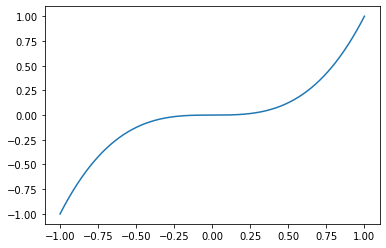

In [376]:
plt.plot(exple, th*100)

In [467]:
x = tf.keras.backend.ones((2, 2))
i = tf.keras.backend.eye(2, dtype='float32')*10
a=x+i
y = tf.keras.backend.ones((2, 2)) 
xy = tf.keras.backend.dot(x, y)
# xy

In [428]:
_dot = tf.keras.backend.dot
_sum = tf.keras.backend.sum

def f(s, s_hat):
    "<s_hat, s>s / ||s||**2"
    a = _sum(_dot(s, s_hat))*s
    b = _sum(_dot(s, s))
    return a/b

f(a, x)

<tf.Tensor: id=1131873, shape=(2, 2), dtype=float32, numpy=
array([[1.3333334, 0.6666667],
       [0.6666667, 1.3333334]], dtype=float32)>

In [469]:
tf.keras.backend.log(i)/np.log(10)

<tf.Tensor: id=1152286, shape=(2, 2), dtype=float32, numpy=
array([[  1., -inf],
       [-inf,   1.]], dtype=float32)>

In [17]:
from tensorflow.python.client import device_lib
with tf.device('/gpu:0'):
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13965586468894694418
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3061527347
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8126309503294165658
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [17]:

import tensorflow as tf
print(tf.__version__)

2.0.0
